# Introducing Attention

© Data Trainers LLC. GPL v 3.0.

**Author:** Axel Sirota

Attention is one of the most groundbreaking ideas that revolutionized NLP and AI on the latest years. However, it is difficult to encounter a demo that is solely focused on attention... until now.

## Prep

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

Let's define some helper functions we need:

* The softmax funciton definition for Numpy arrays
* An Embedder that transforms a list of words into its embedding representation according to `word2vec_sample` from the package `nltk`.


In [30]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

In [31]:
def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = np.array(output)
    del model  # free up space again
    return embeddings, words_pass


## Dot Product Attention

The idea behind attention is simple, if you take any word, like `Apple`, its meaning will change with respect with the other words in the sentence. For example below, In the first sentence Apple refers to the company and has strong relationship with coding and computer; on the second one refers to the fruit and therefore at most it would have relationship with eating, but not coding.

<figure>
<center>
<img src='https://www.dropbox.com/s/91xzqre8dpvxrux/sentence.png?raw=1' alt="drawing" width="350" />
<figcaption>Words relevance change with context</figcaption></center>
</figure>

  What I just spoke, is known as **Cross Attention**, because you will calculate the relationship of one word with respect to **all** the others in the sentence. In an image it would be:


<figure>
<center>
<img src='https://www.dropbox.com/s/ahn8ogriuzasa9a/attention_in_detail.png?raw=1'  />
<figcaption>Attention</figcaption></center>
</figure>

In code it is even easier, don't worry about the image above it will make sense as we evolve through the course. The really important part is the following:

$$
a_{ij} = f(h_i, s_{j})
$$

Where $a_{i,j}$ stands for the alignment of the word `h_i` with the output word `s_j`. The alignment may sound fancy, but it simply means how strongly connected those 2 words are in that sentence, like the Apple example!


The key is that the function $f$ can be anything. In the original paper, and the one we are implementing now it is the dot product, which you have probably seen before, and if not check the course I referenced before,  **Implement Natural Language Processing for Word Embedding**:

$$
a_{i,j} = dot product(h_i, s_j) = h_i^T*s_j
$$

So this means that for a given initial word, which is a row in the matrix we created, we have a Tensor of how aligned it is with that output word; we call that Tensor `c_k` or context vector.

And here comes the important stuff number 2, which is we take softmax to obtain weights, those wieghts will tell me for that input word how much weight (and importance) I should put into any output word. That is the attention matrix.

$$
z_j = softmax_k(c_{j,k})
$$

If we multiply this with the context vector of an encoder we have an empowered context memory tensor that can be fed into the decoder, as it is done in Transformers. We will implement all of this alongside this module

In [44]:
def dot_product_attention(hidden_states, previous_state):

    # # Fill here the final attention weights
    # # [T,d]*[d,N] -> [T,N]
    # scores = None
    # w_n = softmax(scores)

    # # Fill here the weighted average of the weights and hidden states
    # # [T,N]*[N,d] -> [T,d]
    # c_t = None


    scores = np.matmul(previous_state, hidden_states.T)

    w_n = softmax(scores)

    c_t = np.matmul(w_n, hidden_states)

    return w_n, c_t

Now we will use a helper function that will plot those attention weights I told you about

In [45]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

### Testing it out

Let's try with some words related to royalty and some related to food:

<ipython-input-31-1db467097310>:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


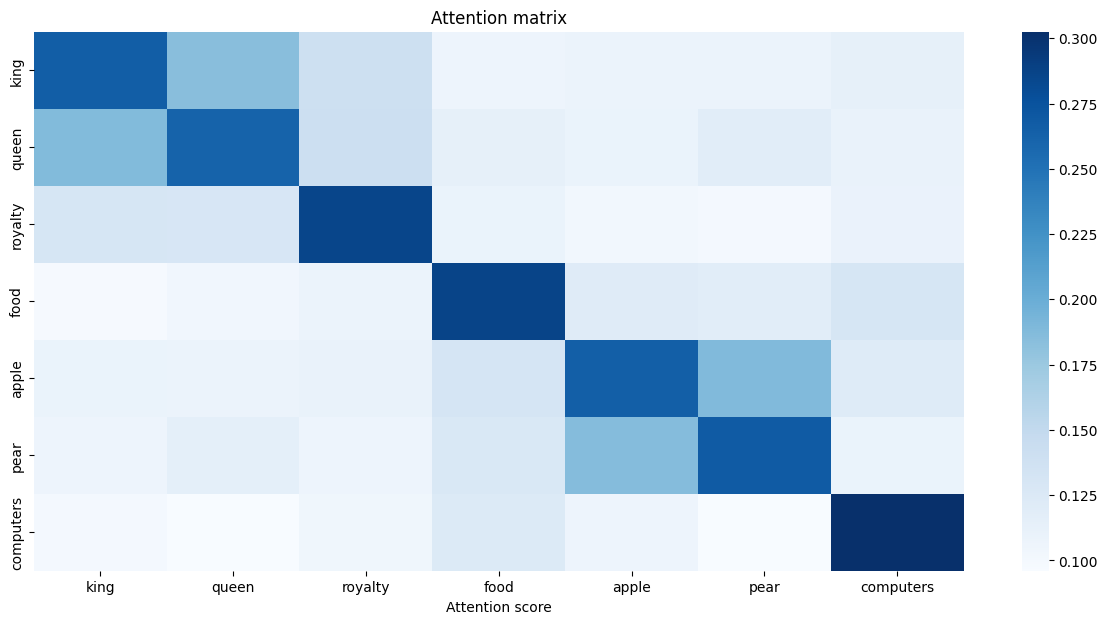

In [46]:
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

As you can see, this was successful! We could detect the relationships between apple, pear and a little less food; aas one cluster. Then another cluster of the royalty, and finally commputers alone, so it detected what it is supposed to! In the next demo we will implement other forms of attention, ie: changing that function `f`

## Introducing self attention

In order to get closer to the Transformer we will neeed to understand Se;f Attention. this concept simply relates attention with a database. In a database you have a key value pair, and with a query you get a key and with that key you return the value, right?

In self-attention ( or sometimes called  Q, K, V attention) we do the same, but instead of getting one key we will get:

$$a_{i, k} = similarity(Q_i, K_k)$$

Therefore

$$ c_i = ∑_{k}a_{i,k}*v_k $$

Which basically means we get a weighted average of **ALL** the values for every input word we want to calculate the alignment. Therefore the term self attention. The diference with the previous attention is that before the similarity function was the dot product, and the matrices `K,Q,V` where the identity (only ones in the diagonal) and here they are learneable!

### Prep

In [47]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

In [48]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = re.sub(r"[^\w\s]", "", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words

### Seeing the attention

In order to see self attention, we just need to do what we did before! But now we will use a variant called **Scaled self attention** which is the one Transformers almost use:

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

It is *very* important to remark all of this later will be done  by the Tensorflow or PyTorch!

In [71]:
def scaled_dot_product_attention(query, key, value):
      # Calculate the dot product of Query and Key
    dot_product = np.matmul(query,np.swapaxes(key, -2, -1))

    # Scale the dot product by the square root of the dimension of key
    scaling_factor = np.sqrt(np.shape(key)[-1], dtype=np.float32)
    scaled_dot_product = dot_product / scaling_factor

    # Apply softmax to obtain attention weights
    attention_weights = softmax(scaled_dot_product)

    # Calculate the weighted sum using attention weights
    weighted_mul = np.matmul(attention_weights, value)

    return weighted_mul, attention_weights

### Testing it out!

In [72]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

<ipython-input-31-1db467097310>:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


(1, 6, 300)

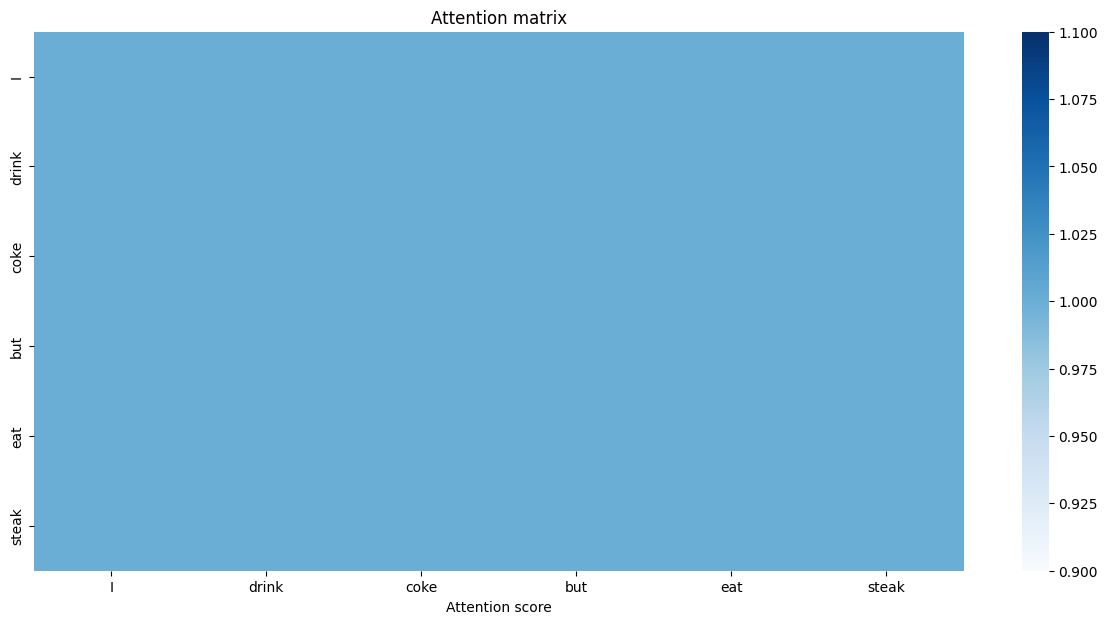

In [73]:
Q = K = V = word_embeddings   # Para no entrenar

# calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = re.sub(r"[^\w\s]", "", sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

In effect you can see a positive alignment between drink and coke, as well as eat and steak.